# Multitask GP Regression using pymc
Source: https://docs.gpytorch.ai/en/latest/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [52]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)

In [53]:
import math
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up training data

In [54]:
train_x = np.linspace(0, 1, 58)

train_y = np.stack([
    np.sin(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (1 * math.pi)) + np.random.randn(len(train_x)) * 0.1,
], -1)

In [55]:
train_x.shape, train_y.shape

((58,), (58, 3))

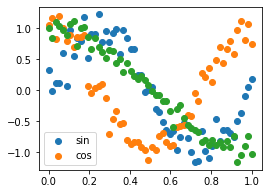

In [56]:
fig, ax = plt.subplots(1,1, figsize=(4,3))
ax.scatter(train_x, train_y[:,0])
ax.scatter(train_x, train_y[:,1])
ax.scatter(train_x, train_y[:,2])
plt.legend(["sin", "cos"])

In [57]:
x = train_x
xx = np.concatenate((x, x, x), axis=0)[:,None]
n = len(x)
idx2 = np.ones(n) + 1
idx = np.concatenate((np.zeros(n), np.ones(n), idx2))[:,None]
X = np.concatenate((xx, idx), axis=1)

y = np.concatenate((train_y[:,0], train_y[:,1], train_y[:,2]))
x.shape, X.shape, y.shape

((58,), (174, 2), (174,))

### Pymc model

In [58]:
X.shape, y.shape

((174, 2), (174,))

In [59]:
from pymc.gp.cov import Covariance

def ICM2(input_dim, num_outputs, kernel, W_rank=1,W=None,kappa=None,name='ICM'):
    """
    Builds a kernel for an Intrinsic Coregionalization Model

    :input_dim: Input dimensionality (does not include dimension of indices)
    :num_outputs: Number of outputs
    :param kernel: kernel that will be multiplied by the coregionalize kernel (matrix B).
    :type kernel: a GPy kernel
    :param W_rank: number tuples of the corregionalization parameters 'W'
    :type W_rank: integer
    """
    if kernel.input_dim != input_dim:
        kernel.input_dim = input_dim
        warnings.warn("kernel's input dimension overwritten to fit input_dim parameter.")

    K = kernel.prod(GPy.kern.Coregionalize(1, num_outputs, active_dims=[input_dim], rank=W_rank,W=W,kappa=kappa,name='B'),name=name)
    return K

class ICM(Covariance):
    def __init__(self, input_dim, active_dims, num_outputs, kernel, W_rank=1,W=None,kappa=None):
        super().__init__(input_dim, active_dims)
        if W is None:
            W = pm.Normal(f"W_{idx}", mu=0, sigma=3, shape=(num_outputs,W_rank), 
                                                            initval=np.random.randn(num_outputs,W_rank))
        if kappa is None:
            kappa = pm.Gamma(f"kappa_{idx}", alpha=1.5, beta=1, shape=num_outputs)        
        coreg = pm.gp.cov.Coregion(input_dim=input_dim, active_dims=active_dims, kappa=kappa, W=W)
        
        self.cov_func = pm.gp.cov.Prod([coreg, cov])

    def __call__(self):
        return self.cov_func
    
    
class LCM(Covariance):
    def __init__(self, input_dim, active_dims, cov_list, n_outputs):
        super().__init__(input_dim, active_dims)
        self.cov_list = cov_list
        self.cov_func = 0
        for idx, cov in enumerate(cov_list):
            kappa = pm.Gamma(f"kappa_{idx}", alpha=1.5, beta=1, shape=n_outputs)
            W = pm.Normal(f"W_{idx}", mu=0, sigma=3, shape=(n_outputs,len(cov_list)), 
                                                            initval=np.random.randn(n_outputs,len(cov_list)))
            coreg = pm.gp.cov.Coregion(input_dim=input_dim, active_dims=active_dims, kappa=kappa, W=W)
            cov_func_ = pm.gp.cov.Prod([coreg, cov])
            self.cov_func = pm.gp.cov.Add([self.cov_func, cov_func_])

    def __call__(self):
        return self.cov_func
    
    
class LCM2(Covariance):
    def __init__(self, input_dim, active_dims, kernel_list, n_outputs):
        super().__init__(input_dim, active_dims)
        self.cov_func = 0
        for idx, kernel in enumerate(kernel_list):
            kappa = pm.Gamma(f"kappa_{idx}", alpha=1.5, beta=1, shape=n_outputs)
            W = pm.Normal(f"W_{idx}", mu=0, sigma=3, shape=(n_outputs,len(cov_list)), 
                                                            initval=np.random.randn(n_outputs,len(cov_list)))
            coreg = pm.gp.cov.Coregion(input_dim=input_dim, active_dims=active_dims, kappa=kappa, W=W)
            cov_func_ = coreg * kernel
            self.cov_func = pm.gp.cov.Add([self.cov_func, cov_func_])

    def __call__(self):
        return self.cov_func

In [60]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(2, ls=ell, active_dims=[0])
    
    ell2 = pm.Gamma("ell2", alpha=2, beta=0.5)
    eta2 = pm.Gamma("eta2", alpha=2, beta=0.5)
    cov2 = eta**2 * pm.gp.cov.Matern32(2, ls=ell, active_dims=[0])
    
    
    
    lcm = LCM2(input_dim=2, active_dims=[1], cov_list=[cov, cov2], n_outputs=3)
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    gp = pm.gp.Marginal(cov_func=lcm())
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma)

In [61]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, ell2, eta2, kappa_0, W_0, kappa_1, W_1, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 315 seconds.


CPU times: user 14min 12s, sys: 25min 35s, total: 39min 47s
Wall time: 5min 23s


In [62]:
x_new = np.linspace(-0.5, 1.5, 200)[:, None]
xx_new = np.concatenate((x_new, x_new, x_new), axis=0)
idx2 = np.ones(200) + 1
idx2 = np.concatenate((np.zeros(200), np.ones(200), idx2))[:, None]
X_new = np.concatenate((xx_new, idx2), axis=1)

In [63]:
X_new.shape

(600, 2)

In [64]:
with model:
    preds = gp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

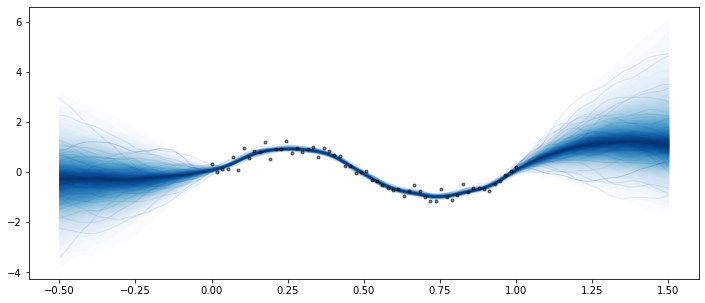

In [65]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
plot_gp_dist(ax, f_pred[:,:200], X_new[:200,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
ax.plot(x, train_y[:,0], 'ok', ms=3, alpha=0.5, label="Data 1");

(-4.0, 4.0)

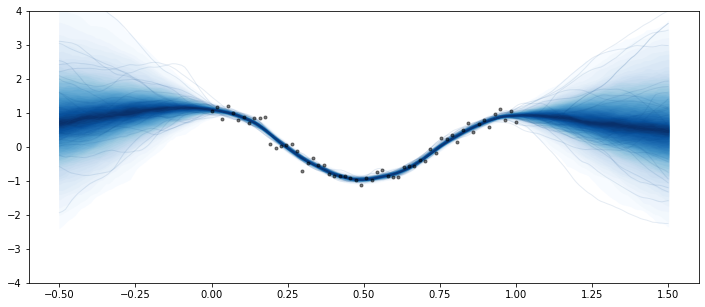

In [66]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

plot_gp_dist(ax, f_pred[:,200:400], X_new[200:400,0], palette="Blues", fill_alpha=0.9, samples_alpha=0.1)
ax.plot(x, train_y[:,1], 'ok', ms=3, alpha=0.5, label="Data 2");
ax.set_ylim([-4,4])

(-4.0, 4.0)

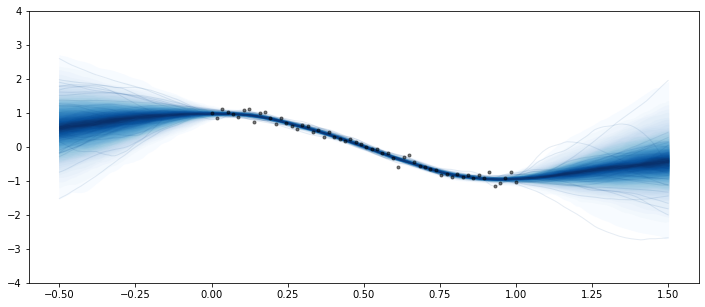

In [67]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

plot_gp_dist(ax, f_pred[:,400:], X_new[400:,0], palette="Blues", fill_alpha=0.9, samples_alpha=0.1)
ax.plot(x, train_y[:,2], 'ok', ms=3, alpha=0.5, label="Data 2");
ax.set_ylim([-4,4])

In [68]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"W_0[0, 0]",-0.050,3.038,-5.177,5.516,0.161,0.131,352.0,358.0,NaN
"W_0[0, 1]",0.154,3.076,-5.295,6.259,0.140,0.125,484.0,395.0,NaN
"W_0[1, 0]",-0.205,3.167,-6.384,5.447,0.176,0.136,330.0,349.0,NaN
"W_0[1, 1]",0.124,3.404,-6.100,6.713,0.210,0.149,263.0,282.0,NaN
"W_0[2, 0]",-0.170,2.624,-5.284,3.910,0.141,0.100,348.0,380.0,NaN
"W_0[2, 1]",-0.033,2.619,-4.751,4.597,0.323,0.230,76.0,358.0,NaN
"W_1[0, 0]",0.244,3.569,-5.726,6.539,0.338,0.240,119.0,160.0,NaN
"W_1[0, 1]",-0.276,3.196,-5.896,5.581,0.235,0.166,182.0,247.0,NaN
"W_1[1, 0]",-0.406,2.718,-5.524,4.551,0.206,0.146,177.0,223.0,NaN
"W_1[1, 1]",0.069,2.838,-4.814,5.420,0.231,0.164,151.0,309.0,NaN


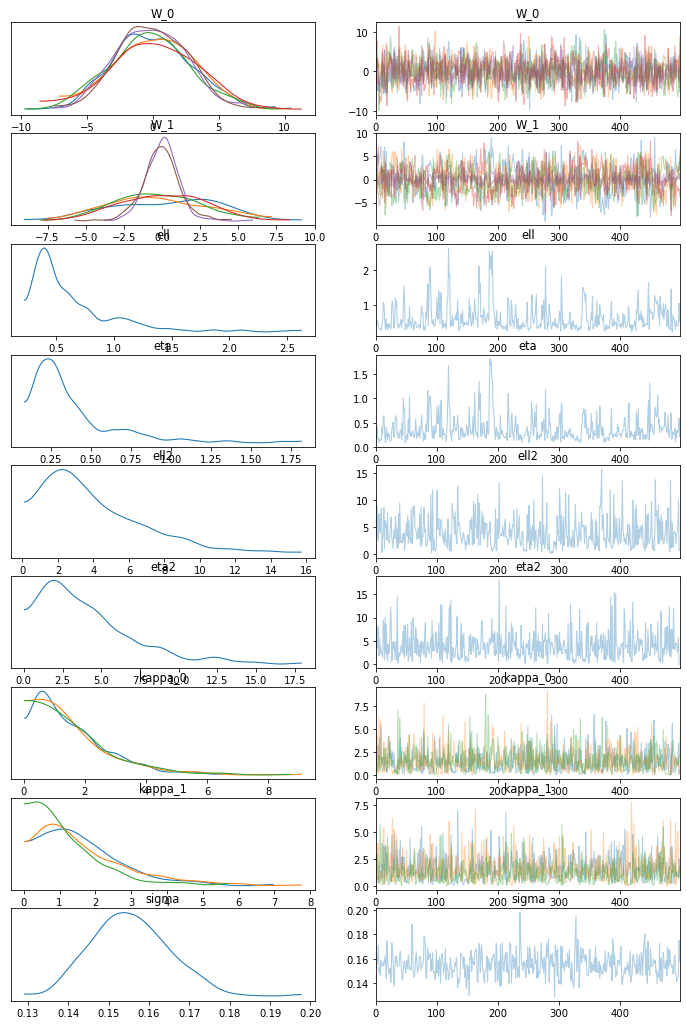

In [69]:
az.plot_trace(gp_trace);